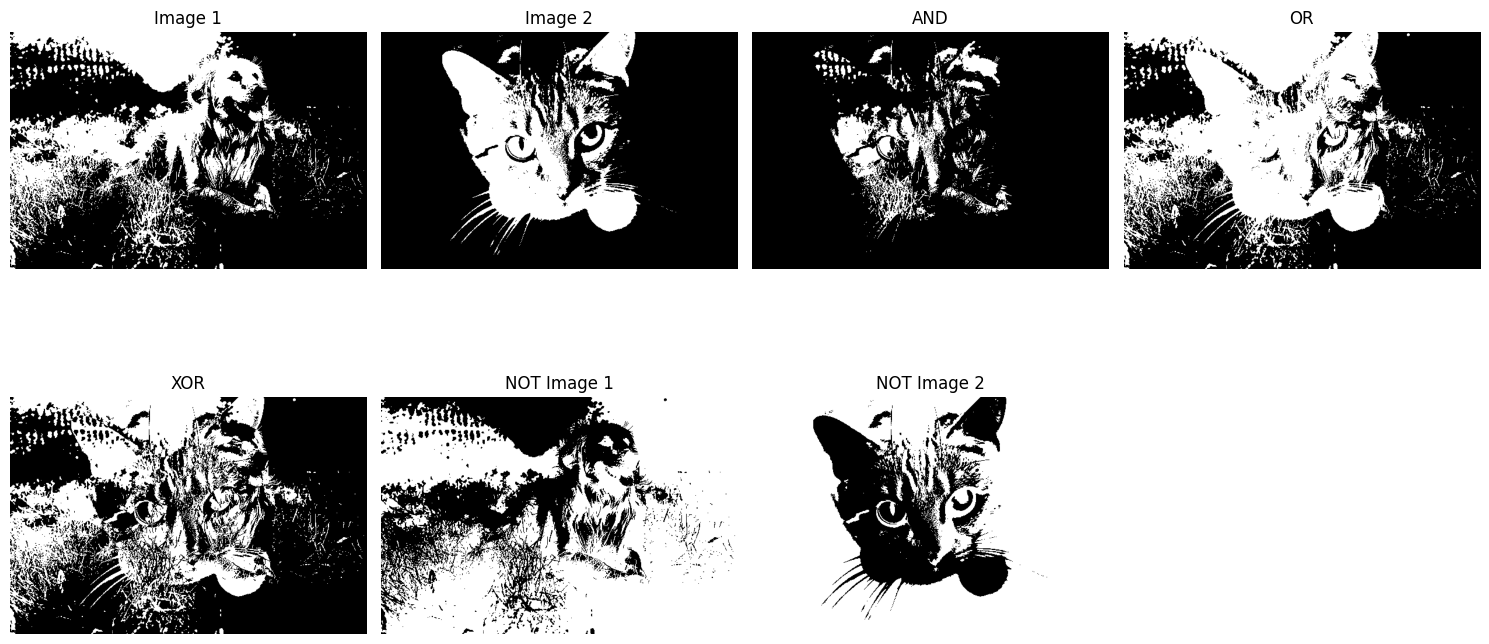

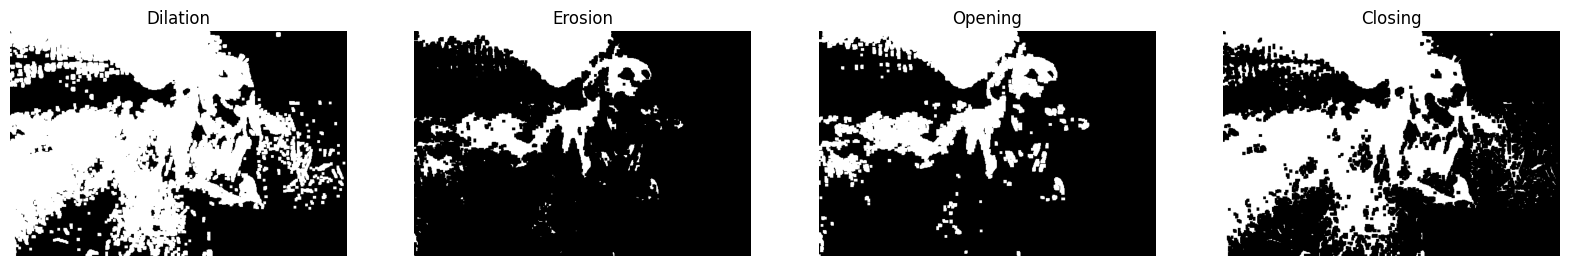

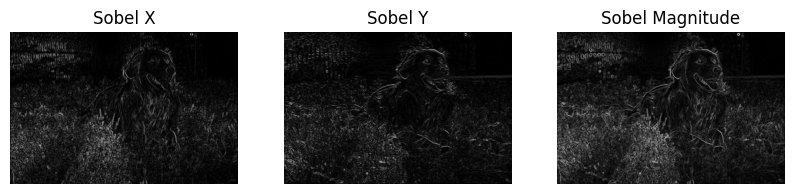

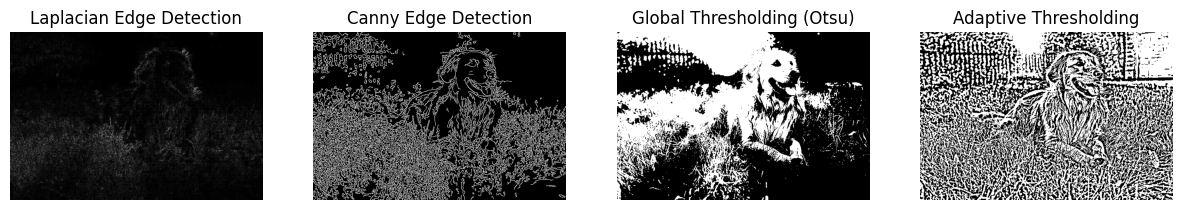

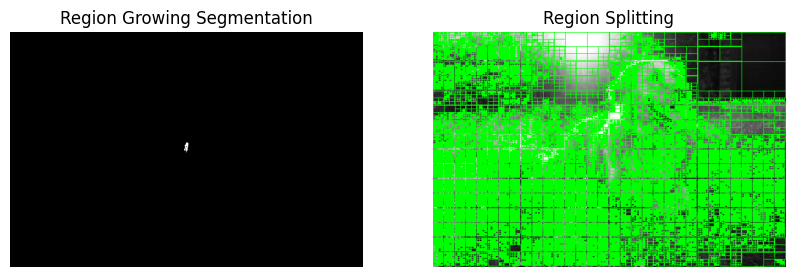

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load two grayscale images (make sure both have the same size!)
img1_path = "img/dog.jpg"
img2_path = "img/cat.jpg"

img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

# Check if images are loaded
if img1 is None:
    print(f"Failed to load image at {img1_path}")
    exit()
if img2 is None:
    print(f"Failed to load image at {img2_path}")
    exit()

# Resize img2 to img1 size if needed
if img1.shape != img2.shape:
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

# Convert images to binary (thresholding)
_, img1_bin = cv2.threshold(img1, 127, 255, cv2.THRESH_BINARY)
_, img2_bin = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY)

# Logical operations
and_img = cv2.bitwise_and(img1_bin, img2_bin)
or_img = cv2.bitwise_or(img1_bin, img2_bin)
xor_img = cv2.bitwise_xor(img1_bin, img2_bin)
not_img1 = cv2.bitwise_not(img1_bin)
not_img2 = cv2.bitwise_not(img2_bin)

# Plot results
titles = ['Image 1', 'Image 2', 'AND', 'OR', 'XOR', 'NOT Image 1', 'NOT Image 2']
images = [img1_bin, img2_bin, and_img, or_img, xor_img, not_img1, not_img2]

plt.figure(figsize=(15,8))
for i in range(len(images)):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


# --- 3. Morphological Operations ---
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))

dilation = cv2.dilate(img1_bin, kernel, iterations=1)
erosion = cv2.erode(img1_bin, kernel, iterations=1)
opening = cv2.morphologyEx(img1_bin, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(img1_bin, cv2.MORPH_CLOSE, kernel)

fig, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].imshow(dilation, cmap='gray'); axs[0].set_title("Dilation")
axs[1].imshow(erosion, cmap='gray'); axs[1].set_title("Erosion")
axs[2].imshow(opening, cmap='gray'); axs[2].set_title("Opening")
axs[3].imshow(closing, cmap='gray'); axs[3].set_title("Closing")
for ax in axs: ax.axis('off')
plt.show()

# --- 4. Edge Detection ---
sobel_x = cv2.Sobel(img1, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(img1, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobel_x, sobel_y)

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.title('Sobel X')
plt.imshow(np.abs(sobel_x), cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Sobel Y')
plt.imshow(np.abs(sobel_y), cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Sobel Magnitude')
plt.imshow(sobel, cmap='gray')
plt.axis('off')
plt.show()

laplacian = cv2.Laplacian(img1, cv2.CV_64F)
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.title("Laplacian Edge Detection")
plt.imshow(np.abs(laplacian), cmap='gray')
plt.axis('off')

canny = cv2.Canny(img1, 100, 200)
plt.subplot(1,4,2)
plt.title("Canny Edge Detection")
plt.imshow(canny, cmap='gray')
plt.axis('off')

# --- 5. Image Segmentation ---
_, otsu = cv2.threshold(img1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.subplot(1,4,3)
plt.title("Global Thresholding (Otsu)")
plt.imshow(otsu, cmap='gray')
plt.axis('off')

adaptive = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                 cv2.THRESH_BINARY, 11, 2)
plt.subplot(1,4,4)
plt.title("Adaptive Thresholding")
plt.imshow(adaptive, cmap='gray')
plt.axis('off')
plt.show()

# Region Growing Function
def region_growing(image, seed, threshold=5):
    h, w = image.shape
    segmented = np.zeros_like(image, dtype=np.uint8)
    to_process = [seed]
    segmented[seed] = 255
    while to_process:
        x, y = to_process.pop(0)
        for nx, ny in [(x-1,y), (x+1,y), (x,y-1), (x,y+1)]:
            if 0 <= nx < h and 0 <= ny < w and segmented[nx, ny] == 0:
                if abs(int(image[nx, ny]) - int(image[x,y])) < threshold:
                    segmented[nx, ny] = 255
                    to_process.append((nx, ny))
    return segmented

seed_point = (img1.shape[0]//2, img1.shape[1]//2)
region_grow_img1 = region_growing(img1, seed_point)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Region Growing Segmentation")
plt.imshow(region_grow_img1, cmap='gray')
plt.axis('off')

# Simple Region Splitting example (quad-tree style)
def split_region(image, x, y, w, h, threshold, segments):
    region = image[x:x+w, y:y+h]
    if np.std(region) < threshold or w <= 1 or h <= 1:
        segments.append((x, y, w, h))
    else:
        hw, hh = w//2, h//2
        split_region(image, x, y, hw, hh, threshold, segments)
        split_region(image, x+hw, y, hw, hh, threshold, segments)
        split_region(image, x, y+hh, hw, hh, threshold, segments)
        split_region(image, x+hw, y+hh, hw, hh, threshold, segments)

segments = []
split_region(img1, 0, 0, img1.shape[0], img1.shape[1], threshold=10, segments=segments)

img_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
for (x, y, w, h) in segments:
    cv2.rectangle(img_color, (y,x), (y+h, x+w), (0, 255, 0), 1)

plt.subplot(1,2,2)
plt.title("Region Splitting")
plt.imshow(img_color)
plt.axis('off')
plt.show()
